In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import itertools

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, \
    accuracy_score, label_ranking_average_precision_score, classification_report, roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
data_dir = 'D:/Road_signs'
categories = ['priority_signs', 'warning_signs', 'mandatory_signs']
img_size = 32
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        image_array = cv2.resize(img_array, (img_size, img_size))

In [9]:
train_data = []
X = []
y = []

In [10]:
for i in categories:
    train_path = os.path.join(data_dir, i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        image_arr = cv2.imread(os.path.join(train_path, img), cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(image_arr, (img_size, img_size))
        train_data.append([new_image_array, tag])

In [11]:
for i, j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1, img_size, img_size)
print(X.shape)

(8036, 32, 32)


In [12]:
X = X / 255.0
X = X.reshape(-1, 32, 32, 1)

y_enc = to_categorical(y, num_classes=3)

print(y_enc)
print(X)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[[[1.        ]
   [1.        ]
   [1.        ]
   ...
   [0.52156863]
   [0.98823529]
   [0.99607843]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [0.4627451 ]
   [0.89411765]
   [0.98039216]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [0.43137255]
   [0.76078431]
   [0.97254902]]

  ...

  [[0.98039216]
   [0.88235294]
   [0.9254902 ]
   ...
   [0.43529412]
   [0.42745098]
   [0.43137255]]

  [[1.        ]
   [0.99215686]
   [1.        ]
   ...
   [0.41568627]
   [0.42745098]
   [0.40784314]]

  [[0.99607843]
   [0.99607843]
   [1.        ]
   ...
   [0.40392157]
   [0.41568627]
   [0.40784314]]]


 [[[0.93333333]
   [0.96078431]
   [1.        ]
   ...
   [0.39607843]
   [0.47058824]
   [0.8745098 ]]

  [[0.99607843]
   [0.99215686]
   [0.99215686]
   ...
   [0.38823529]
   [0.43529412]
   [0.87058824]]

  [[0.82745098]
   [0.98823529]
   [1.        ]
   ...
   [0.38431373]
  

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(32, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding = 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(3, activation="softmax"))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1664      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 8, 8, 128)        

In [22]:
epochs = 50

es = EarlyStopping(monitor='val_acc', mode='max', patience=3)

batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        zoom_range=0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=True,
        vertical_flip=False)

In [23]:
imggen.fit(X_train)
history = model.fit_generator(imggen.flow(X_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_val, y_val),
                              steps_per_epoch=X_train.shape[0] // batch_size)

<ipython-input-23-c337ac4ac199>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(imggen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/50
321/321 [==============================] - 15s 46ms/step - loss: 1.0891 - accuracy: 0.4027 - val_loss: 1.0867 - val_accuracy: 0.4184
Epoch 2/50
321/321 [==============================] - 14s 44ms/step - loss: 1.0787 - accuracy: 0.4237 - val_loss: 1.0818 - val_accuracy: 0.4184
Epoch 3/50
321/321 [==============================] - 14s 43ms/step - loss: 1.0774 - accuracy: 0.4233 - val_loss: 1.0796 - val_accuracy: 0.4184
Epoch 4/50
321/321 [==============================] - 14s 45ms/step - loss: 1.0743 - accuracy: 0.4233 - val_loss: 1.0756 - val_accuracy: 0.4184
Epoch 5/50
321/321 [==============================] - 15s 45ms/step - loss: 1.0714 - accuracy: 0.4241 - val_loss: 1.0703 - val_accuracy: 0.4184
Epoch 6/50
321/321 [==============================] - 14s 44ms/step - loss: 1.0653 - accuracy: 0.4239 - val_loss: 1.0629 - val_accuracy: 0.4184
Epoch 7/50
321/321 [==============================] - 14s 44ms/step - loss: 1.0603 - accuracy: 0.4259 - val_loss: 1.0518 - val_accuracy:

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Metrix =  ', score[1])
predictions = model.predict(X_test, batch_size=32)
print('LRAP =  ', label_ranking_average_precision_score(y_test, predictions))

Metrix =   0.9682835936546326
LRAP =   0.9832089552238804


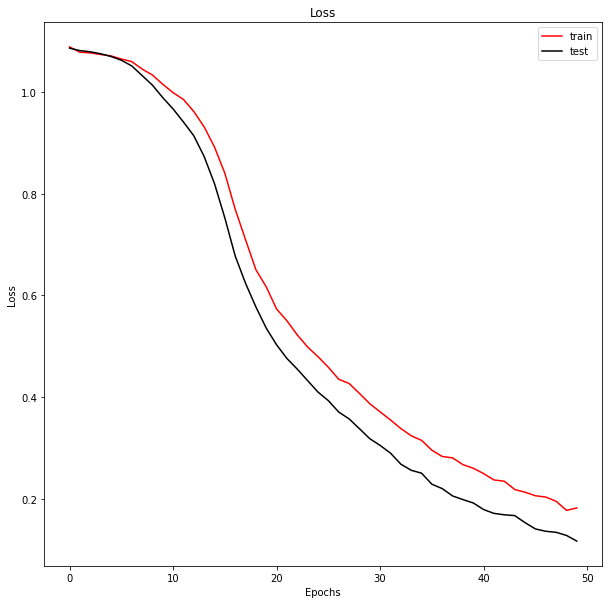

In [30]:
plt.plot(history.history["loss"], c="red")
plt.plot(history.history["val_loss"], c="black")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

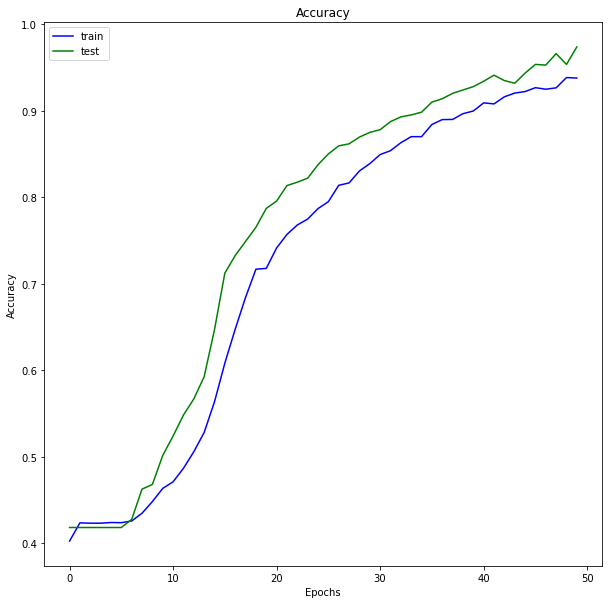

In [31]:
plt.plot(history.history["accuracy"], c="blue")
plt.plot(history.history["val_accuracy"], c="green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()